In [1]:
%%time
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


# Clean the input directory structure.
! rm -rf cmp23 preprocessed features
! mkdir -p {.,preprocessed}/cmp23/{fe,}male features

# Self explanatory.
! cp ../input/cmp23-handwritten-males-vs-females/Males/Males/* cmp23/male
! cp ../input/cmp23-handwritten-males-vs-females/Females/Females/* cmp23/female

# Rename all the dataset files to simple names.
! function rename { for path in "$@"; do cd $path; c=1; for file in $(ls); do mv $file $c.jpg; let c=c+1; done; cd - >/dev/null; done; }; rename cmp23/{fe,}male

# Check the directory tree.
! tree --filelimit 100

.
├── __notebook__.ipynb
├── cmp23
│   ├── female [131 entries exceeds filelimit, not opening dir]
│   └── male [232 entries exceeds filelimit, not opening dir]
├── features
└── preprocessed
    └── cmp23
        ├── female
        └── male

8 directories, 1 file
CPU times: user 137 ms, sys: 42.6 ms, total: 180 ms
Wall time: 10.3 s


In [2]:
# Imports.
import os
import glob
import cv2
import functools
import numpy as np
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern, hog

In [3]:
# Helper functions.
def cmp(gender: str, id: int):
    return f'cmp23/{gender}/{str(id)}.jpg'

def is_male(path: str):
    return 'female' not in path

def gender(path: str):
    return 1 if is_male(path) else 0

def pre(image_path: str):
    return f'preprocessed/{image_path}'

def feat(feature: str):
    return f'features/{feature}.ft'

def preview(images: list):
    fig = plt.figure(figsize=(20, 20))
    for i, image_path in enumerate(images):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        fig.add_subplot(4, 4, i + 1)
        plt.imshow(image, cmap='gray')
    plt.show()

def imread_bw(image_path: str):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return np.where(image > 255 / 2, 1, 0)

def prune_useless_feature_cols(features):
    zero_cols = features[0] == features[1]
    for feature_vec in features:
        zero_cols &= features[0] == feature_vec
    print(f'The following {np.sum(zero_cols)} features were removed because they are not discriminative:')
    features_to_remove = np.where(zero_cols, [x + 1 for x in range(len(zero_cols))], -1)
    print(features_to_remove[features_to_remove != -1])
    return features[:, ~zero_cols]

def norm(features):
    features = prune_useless_feature_cols(np.array(features))
    features = normalize(features, axis=0)
    # Ceil all the fractions (representing male class) back to one.
    features[features[:, -1] > 0, -1] = 1
    return features

def ojalat_lbp(image, n_points=16, radius=2):
    lbp = local_binary_pattern(image, n_points, radius, method='nri_uniform')
    # [n * (n - 1) + 2] for uniform bp and [1] more bin for non uniform bp.
    n_bins = n_points * (n_points - 1) + 2 + 1
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(n_bins + 1))
    return hist

In [4]:
# Constants.
ALL_IMAGES = glob.glob(cmp('*', '*'))

TST_IMAGES = [
    cmp('female', 9),
    cmp('male', 67),
    cmp('male', 89),
    cmp('female', 3),
    cmp('male', 12),
    cmp('female', 4),
] # Some images' paths used oberservation.

PREPROCESSING_GAUSSIAN_BLUR_KERNEL_SIZE = (9, 9)
PREPROCESSING_DILATION_ITERATIONS = 8
PREPROCESSING_DILATION_SIZE = (15, 20) # We need more dilation into the vertical axis.
PREPROCESSING_THRESH_BLOCK_SIZE = 101 # 101 is quick enough, yet robust.
PREPROCESSING_THRESH_C = 30 # Note that we need a big C subtractor when we use a big block size.
X_CUT_PERCENT = 0.1 # Don't cut too much since some people write to edge of the paper.
Y_CUT_PERCENT = 0.5 # 0.5% on both sides is enough.

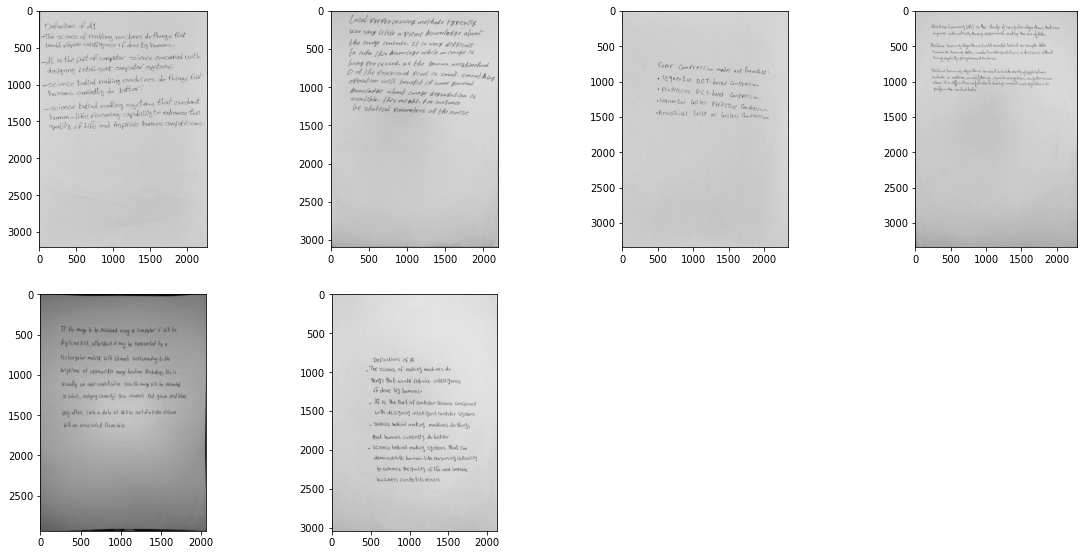

In [5]:
# Preview the test images before preprocessing them.
preview(TST_IMAGES)

In [6]:
%%time
# Preprocess the images and write them to the disk.
for image_path in ALL_IMAGES:
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Cut some percentage of the images' edges. They are usually noisy.
    height, width = image.shape
    if X_CUT_PERCENT:
        start_x, end_x = int(width / (100/X_CUT_PERCENT)), width - int(width / (100/X_CUT_PERCENT))
        image = image[:, start_x:end_x]
    if Y_CUT_PERCENT:
        start_y, end_y = int(height / (100/Y_CUT_PERCENT)), height - int(height / (100/Y_CUT_PERCENT))
        image = image[start_y:end_y, :]
    # Blur the image to decrease sharpness. Good for thresholding.
    img = cv2.GaussianBlur(image, PREPROCESSING_GAUSSIAN_BLUR_KERNEL_SIZE, 0)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,
                                PREPROCESSING_THRESH_BLOCK_SIZE, PREPROCESSING_THRESH_C)
    # Dilate the image to create a contour out of the handwritten text.
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, PREPROCESSING_DILATION_SIZE)
    img = cv2.dilate(img, kernel, iterations=PREPROCESSING_DILATION_ITERATIONS)
    contours = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    # Get the biggest contour that contains the text.
    biggest_contour = functools.reduce(lambda c1, c2: c1 if cv2.contourArea(c1) > cv2.contourArea(c2) else c2,
                                       contours)
    # Get the original image in black and white. Note that this version is not blured.
    image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,
                                  PREPROCESSING_THRESH_BLOCK_SIZE, PREPROCESSING_THRESH_C)
    image = cv2.threshold(image, 255 / 2, 255, cv2.THRESH_BINARY)[1]
    # Crop only the text part.
    x, y, w, h = cv2.boundingRect(biggest_contour)
    image = image[y:y + h, x:x + w]
    # Write the preprocessed image to the disk.
    cv2.imwrite(pre(image_path), image)

CPU times: user 3min 34s, sys: 4.55 s, total: 3min 39s
Wall time: 3min 29s


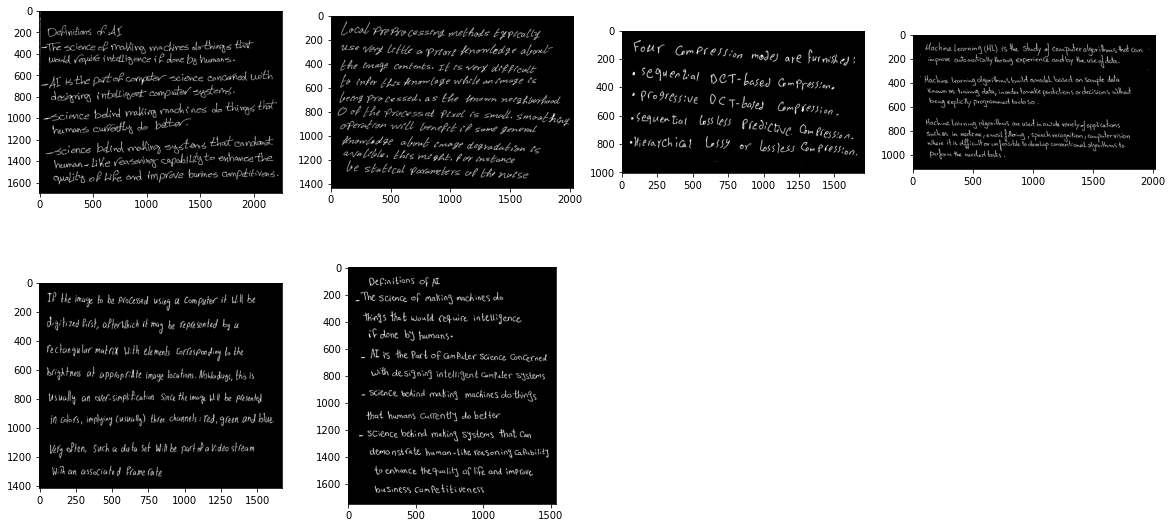

In [7]:
# Preview the test images after preprocessing.
preview(map(pre, TST_IMAGES))

In [8]:
def svm_test(features, times=100, test_size=0.2, **kwargs):
    tr_ac, ts_ac, mal, fem = 0, 0, 0, 0
    for i in range(times):
        X_train, X_test, y_train, y_test = train_test_split(features[:,:-1], features[:,-1], test_size=test_size)
        clf = svm.SVC(**kwargs)
        clf.fit(X_train, y_train)
        tr_ac += clf.score(X_train, y_train)
        ts_ac += clf.score(X_test, y_test)
        mal += np.sum(clf.predict(features[:,:-1]) == 1) / len(features[:,:-1])
        fem += np.sum(clf.predict(features[:,:-1]) == 0) / len(features[:,:-1])
    ret = ts_ac * 100 / times, tr_ac * 100 / times, mal * 100 / times, fem * 100 / times
    print('male_predict% = {}\nfemale_predict% = {}'.format(*ret[2:]))
    return ret[:2]

def ann_test(features):
    pass

def plt_test(features):
    males = features[features[:,-1] == 1]
    females = features[features[:,-1] == 0]
    for f1 in range(0, len(males[0,:-1])):
        print(f1)
        plt.plot(males[:, f1], males[:, -1], 'bo')
        plt.plot(females[:, f1], females[:, -1], 'rx')
        plt.show()

In [9]:
%%time
# GLCM features.
cmp_features = []

angles=[0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]
distances = [1]
props = ['contrast', 'homogeneity', 'energy', 'correlation', 'entropy']

for image_path in map(pre, ALL_IMAGES):
    image = imread_bw(image_path)
    glcm = graycomatrix(image, distances=distances, angles=angles, levels=2, symmetric=False, normed=True)
    features = []
    for prop in props:
        if prop == 'entropy':
            # Since graycoprops doesn't support calculating entropy.
            features.append([-np.sum(glcm[:, :, d, a] * np.log(glcm[:, :, d, a])) for d in range(len(distances)) for a in range(len(angles))])
        else:
            features.append(graycoprops(glcm, prop).ravel())
    features.append(gender(image_path))
    cmp_features.append(np.hstack(features))

# Normalize the features and save them.
np.savetxt(feat('glcm'), norm(cmp_features))

The following 0 features were removed because they are not discriminative:
[]
CPU times: user 25.3 s, sys: 267 ms, total: 25.6 s
Wall time: 25.6 s


In [10]:
features = np.loadtxt(feat('glcm'))
svm_test(features, C=10, kernel='rbf', times=100)

male_predict% = 76.39393939393943
female_predict% = 23.606060606060606


(67.31506849315073, 76.07241379310346)

In [11]:
%%time
# LBP features.
cmp_features = []

for image_path in map(pre, ALL_IMAGES):
    image = imread_bw(image_path)
    cmp_features.append(np.append(ojalat_lbp(image, n_points=20),
                                  gender(image_path)))

# Normalize the features and save them.
np.savetxt(feat('lbp'), norm(cmp_features))

The following 252 features were removed because they are not discriminative:
[  3   4   5   6   8   9  10  11  13  14  15  16  18  19  20  21  24  26
  29  31  34  36  39  41  42  44  45  46  47  49  50  51  52  54  55  56
  57  59  60  61  63  64  66  68  69  71  73  74  76  78  79  81  82  84
  86  87  89  91  92  94  96  97  99 101 103 104 105 106 108 109 110 111
 113 114 115 116 118 119 120 121 124 126 129 131 134 136 139 141 142 144
 145 146 147 149 150 151 152 154 155 156 157 159 160 161 163 164 166 168
 169 171 173 174 176 178 179 181 182 184 186 187 189 191 192 194 196 197
 199 201 203 204 205 206 208 209 210 211 213 214 215 216 218 219 220 221
 224 226 229 231 234 236 239 241 242 244 245 246 247 249 250 251 252 254
 255 256 257 259 260 261 263 264 266 268 269 271 273 274 276 278 279 281
 282 284 286 287 289 291 292 294 296 297 299 301 303 304 305 306 308 309
 310 311 313 314 315 316 318 319 320 321 324 326 329 331 334 336 339 341
 342 344 345 346 347 349 350 351 352 354 355 35

In [12]:
features = np.loadtxt(feat('lbp'))
svm_test(features, C=10, kernel='rbf', times=100)

male_predict% = 65.69696969696966
female_predict% = 34.303030303030305


(73.87671232876708, 96.15517241379315)

In [13]:
%%time
# HoG features.
cmp_features = []

resize_w, resize_h = (0, 0)
for image_path in map(pre, ALL_IMAGES):
    image = imread_bw(image_path)
    resize_h += image.shape[0]
    resize_w += image.shape[1]

# Get the average width and height.
resize_w, resize_h = resize_w / len(ALL_IMAGES), resize_h / len(ALL_IMAGES)
# Upscale the resize parameters so not to lose any resolution.
resize_factor = int(resize_w * 1.15), int(resize_h * 1.15)

for image_path in map(pre, ALL_IMAGES):
    image = imread_bw(image_path).astype('float')
    image = cv2.resize(image, resize_factor)
    features = hog(image, orientations=9, pixels_per_cell=(16, 16),
                   cells_per_block=(1, 1), transform_sqrt=False)
    features = np.append(features.ravel(), gender(image_path))
    cmp_features.append(features)

cmp_features = np.array(cmp_features)
cmp_features = np.append(PCA().fit_transform(cmp_features[:,:-1]), cmp_features[:,[-1]], axis=1)
# Normalize the features and save them.
np.savetxt(feat('hog'), norm(cmp_features))

The following 0 features were removed because they are not discriminative:
[]
CPU times: user 4min 54s, sys: 12.3 s, total: 5min 6s
Wall time: 4min 29s


In [14]:
features = np.loadtxt(feat('hog'))
svm_test(features, C=10, kernel='rbf', times=100)

male_predict% = 71.25619834710746
female_predict% = 28.743801652892554


(63.47945205479452, 100.0)